# Network Analysis

Network Science is a subset of Data Science which deals with data which can be depicted in the form of networks. A simple example of a network would be a chain of email exchanges between numerous employees in an organization.


## Dataset Used

In this Notebook, I have used the publicly available Enron dataset. Enoron was an American energy, commodities, and services speculator that went bankrupt in late 2001 as a result of fraudulent activity.The Enron Scandal involves Enron deceiving regulators through off-the-books accounting practices and the incorporation of phony holdings. The dataset we’re using is the Enron Corpus, which contains data from over half a million emails between the company’s employees and was obtained by the Federal Energy Regulatory Commission during the investigation into its demise.
The dataset I’ve used contains data from about users, mostly senior management of Enron. The corpus contains a total of about half a million messages. For my analysis I've worked on the first 50 thousand rows. This dataset was obtained by the Federal Energy Regulatory Commission during its investigation of Enron’s collapse. We have obtained the dataset from https://www.cs.cmu.edu/~./enron/. 

### Primary Libraries Utilized

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

### Loading our dataset

I am utilizing only the first 50,000 rows of data

In [2]:
email_df = pd.read_csv('emails.csv', nrows = 50000)

In [3]:
email_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file     50000 non-null  object
 1   message  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
email_df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


### Data cleaning

For network analysis, the dataset must be properly prepared and cleaned. The dataset currently has two columns: file and message. The’message’ column contains information about the sender, recipient, and email text.
1. Removing Noisy Data: I first removed all the rows where the ’message’ column does not not follow the standard format. This will make our extraction easier.
2. Extracting: From the the ’message’ column we extract relevant information for our anal- ysis purpose. I got the date, the send id, the receiver id and the message itself and make columns respectively.
3. Creating Word Flags: Based on the key words present in the email transcript we are adding a flag column to indicate the presence of that word in the email.
4. Data Aggregations: Multiple data aggregations are built for various analyses and network styles.


In [ ]:
def standard_format(df, Series, string, slicer):
    """Drops rows containing messages without some specified value in the expected locations. 
    Returns original dataframe without these values. Don't forget to reindex after doing this!!!"""
    rows = []
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        if string not in message_words[slicer]:
            rows.append(row)
    df = df.drop(df.index[rows])
    return df

def get_text(Series, row_num_slicer):
    """returns a Series with text sliced from a list split from each message. Row_num_slicer
    tells function where to slice split text to find only the body of the message."""
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        del message_words[:row_num_slicer]
        result.iloc[row] = message_words
    return result

def get_row(Series, row_num):
    """returns a single row split out from each message. Row_num is the index of the specific
    row that you want the function to return."""
    result = pd.Series(index=Series.index)
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        message_words = message_words[row_num]
        result.iloc[row] = message_words
    return result

def get_address(df, Series, num_cols=1):
    """returns a specified email address from each row in a Series"""
    address = re.compile('[\w\.-]+@[\w\.-]+\.\w+')
    addresses = []
    result1 = pd.Series(index=df.index)
    result2 = pd.Series(index=df.index)
    result3 = pd.Series(index=df.index)
    for i in range(len(df)):
        for message in Series:
            correspondents = re.findall(address, message)
            addresses.append(correspondents)
            result1[i] = addresses[i][0]
        if num_cols >= 2:
            if len(addresses[i]) >= 3:
                result2[i] = addresses[i][1]
                if num_cols == 3:
                    if len(addresses[i]) >= 4:
                        result3[i] = addresses[i][2]
    return result1, result2, result3

def standard_format(df, Series, string, slicer):
    """Drops rows containing messages without some specified value in the expected locations. 
    Returns original dataframe without these values. Don't forget to reindex after doing this!!!"""
    rows = []
    for row, message in enumerate(Series):
        message_words = message.split('\n')
        if string not in message_words[slicer]:
            rows.append(row)
    df = df.drop(df.index[rows])
    return df

# Remove emails that are faulty or erroraneous 
length_emails = len(email_df.index)
headers = ['Message-ID: ', 'Date: ', 'From: ', 'To: ', 'Subject: ']
for i, v in enumerate(headers):
    email_df = standard_format(email_df, email_df.message, v, i)
email_df = email_df.reset_index()
print("Got rid of {} useless emails! That's {}% of the total number of messages in this dataset.".format(length_emails - len(email_df.index), np.round(((length_emails - len(email_df.index)) / (length_emails)) * 100, decimals=2)))

# Extract relevant columns from the message column
data = email_df

data['text'] = get_text(data.message, 15)
data['date'] = get_row(data.message, 1)
data['senders'] = get_row(data.message, 2)
data['recipients'] = get_row(data.message, 3)

data.date = data.date.str.replace('Date: ', '')
data.date = pd.to_datetime(data.date)

# Additional columns can be utilized as wished, although for my analysis - I am limiting the scope.
data['recipient1'], data['recipient2'], data['recipient3'] = get_address(data, data.recipients, num_cols=3)
data['sender'], x, y = get_address(data, data.senders)

del data['recipients']
del data['senders']
del data['file']
del data['message']

Got rid of 12485 useless emails! That's 24.97% of the total number of messages in this dataset.


In [9]:
data = data.reset_index()
data_cleaned = data[['date', 'sender', 'recipient1']]
data_cleaned['email'] = [''.join(data['text'][i]) for i in range(0,len(data))]
print(data_cleaned.head())

                        date                      sender  \
0  2000-12-08 09:42:00-08:00      brad.richter@enron.com   
1  2000-12-08 09:30:00-08:00   annemarie.allex@enron.com   
2  2000-12-13 10:05:00-08:00      shona.wilson@enron.com   
3  2000-12-08 06:36:00-08:00      sheri.thomas@enron.com   
4  2000-12-08 02:36:00-08:00  arsystem@mailman.enron.com   

                 recipient1                                              email  
0      sally.beck@enron.com  ['', 'Sally--', '', "I'm pretty sure that I sa...  
1      sally.beck@enron.com  ['X-Origin: Beck-S', 'X-FileName: sbeck.nsf', ...  
2  patti.thompson@enron.com  ['', '---------------------- Forwarded by Shon...  
3  patti.thompson@enron.com  ['X-Origin: Beck-S', 'X-FileName: sbeck.nsf', ...  
4      sally.beck@enron.com  ['', 'You have received this email because you...  


<ipython-input-9-1490b13d2f70>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['email'] = [''.join(data['text'][i]) for i in range(0,len(data))]


### Exploratory Data Analysis

In [10]:
emails_sent_df = data[['sender']].value_counts().reset_index().head(10)
emails_sent_df.columns = ['Sender', 'Emails Sent']

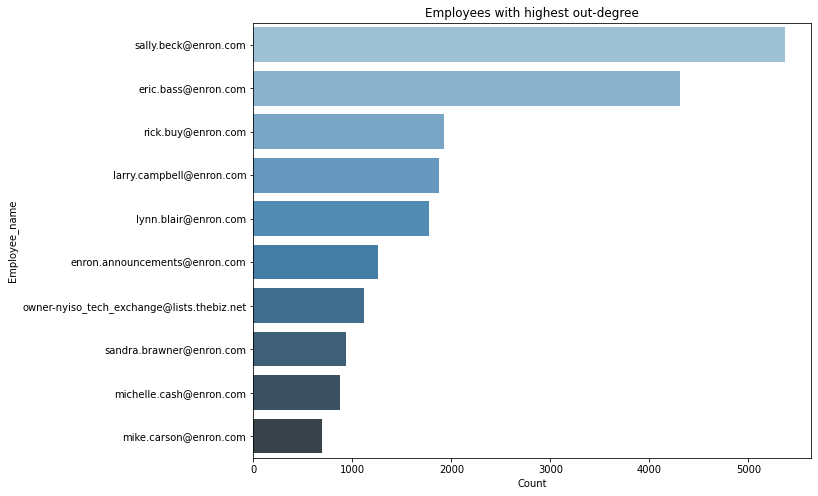

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))

sns.barplot(y="Sender", x="Emails Sent", data=emails_sent_df, palette="Blues_d")
plt.title("Employees with highest out-degree")
plt.xlabel("Count")
plt.ylabel("Employee_name")
plt.show()

In [12]:
x = data[['recipient1']].value_counts().reset_index().head(10)
x.columns = ['Receiver', 'Emails Received']

In [13]:
data[['date', 'sender', 'recipient1', 'text']].head()

,date,sender,recipient1,text
0,2000-12-08 09:42:00-08:00,brad.richter@enron.com,sally.beck@enron.com,"['', 'Sally--', '', ""I'm pretty sure that I sa..."
1,2000-12-08 09:30:00-08:00,annemarie.allex@enron.com,sally.beck@enron.com,"['X-Origin: Beck-S', 'X-FileName: sbeck.nsf', ..."
2,2000-12-13 10:05:00-08:00,shona.wilson@enron.com,patti.thompson@enron.com,"['', '---------------------- Forwarded by Shon..."
3,2000-12-08 06:36:00-08:00,sheri.thomas@enron.com,patti.thompson@enron.com,"['X-Origin: Beck-S', 'X-FileName: sbeck.nsf', ..."
4,2000-12-08 02:36:00-08:00,arsystem@mailman.enron.com,sally.beck@enron.com,"['', 'You have received this email because you..."


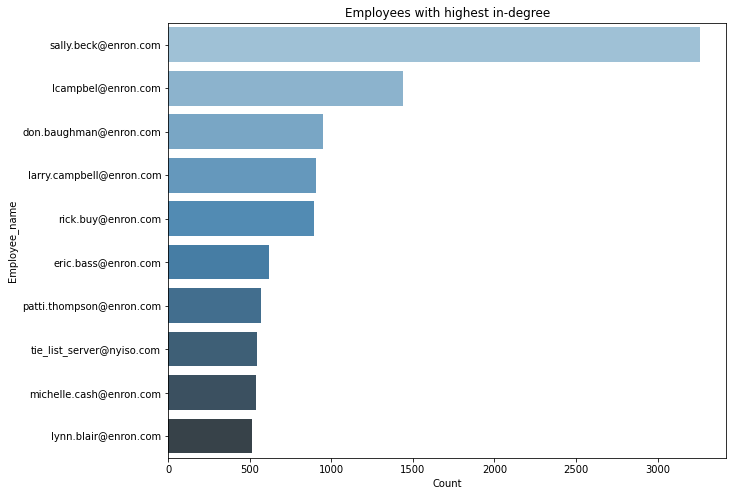

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))

sns.barplot(y="Receiver", x="Emails Received", data=x, palette="Blues_d")
plt.title("Employees with highest in-degree")
plt.xlabel("Count")
plt.ylabel("Employee_name")
plt.show()

In [15]:
x = data[['sender', 'recipient1']].value_counts().reset_index()
x.columns = ['Sender', 'Receiver', 'Directed Links(Emails)']
x.head(10)

,Sender,Receiver,Directed Links(Emails)
0,sally.beck@enron.com,patti.thompson@enron.com,508
1,eric.bass@enron.com,shanna.husser@enron.com,491
2,owner-nyiso_tech_exchange@lists.thebiz.net,marketrelations@nyiso.com,373
3,eric.bass@enron.com,jason.bass2@compaq.com,371
4,mailbot@datek.com,lcampbel@enron.com,345
5,enron.announcements@enron.com,all.houston@enron.com,293
6,enron.announcements@enron.com,all.worldwide@enron.com,278
7,owner-nyiso_tech_exchange@lists.thebiz.net,tie_list_server@nyiso.com,274
8,eric.bass@enron.com,daphneco64@bigplanet.com,272
9,eric.bass@enron.com,timothy.blanchard@enron.com,266


## Part 1 - Network Analysis


Our initial network consists of 3400 nodes or employees connected by 4542 links. The network depicted is an undirected network that shows which employees in the organization have been part of the same email chain. At the moment, the edges depicted have no weight. Using Python’s networkx package, I was able to obtain network attributes such as degree central- ity, betweenness centrality, closeness centrality, and eigenvector centrality. This network was then constructed in the network visualization tool Gephi using these metrics.

Gephi was used to find the communities in the network, with a modularity of 2 set. More than 200 communities were represented in the network. Upon inspection of the communities, these could be described as Enron’s internal teams. Because we are unable to visualize all 200 communities, we have chosen to filter the top eight communities because they are large enough.

I used degree centrality to identify the key players in each community. Sally Beck, Don Bough- man, Rick Buy, Michelle Cash, and a few other notable employees appear to be well-known in this network. The nodes were sized based on betweenness centrality, which tells us who is most influential in spreading information within and between communities.

This network represents an overview of the entire corpus, and my subsequent analysis will delve deeper into some key aspects.

### Graph 1

![title](graphs/one.png)


In [ ]:
import networkx as nx
G1 = nx.from_pandas_edgelist(data, 'sender', 'recipient1', create_using=nx.Graph())
nx.info(G1)

In [ ]:
eigen = nx.eigenvector_centrality(G1)
betweeness = nx.betweenness_centrality(G1)
closeness = nx.closeness_centrality(G1)
degree = nx.degree_centrality(G1)

In [ ]:
nx.set_node_attributes(G1, eigen, 'eigen_vector')
nx.set_node_attributes(G1, betweeness, 'betweeness')
nx.set_node_attributes(G1, closeness, 'closeness')
nx.set_node_attributes(G1, degree, 'degree')

In [ ]:
print("Eigen vector centrality:", eigen)

In [ ]:
nx.write_gexf(G1, 'graph1_50k.gexf')

### Graph 2

This network consists of 3400 nodes or employees connected by 5275 links. In this directed graph the weight of each edge signifies the number of emails between those two nodes. The thickness of edge represents the number of emails sent between those two nodes. It is clear from this visualization that Sally Beck, the then COO of the company, is responsible for sending out more emails than any other employee in this sub network.
The number of direct connections a person/node has is measured by degree centrality. Higher degree centrality is associated with larger node size in this demonstration. Someone at the very top of the food chain is likely to have a few connections, but not the most. They should only speak with ’department heads’ or their equivalents. We have also depicted the in-degree of each node by it’s size, where Michelle Cash and Don Baughman have a high in-degree, which is primarily coming from employees out of this sub-network.

![title](graphs/two.png)


In [ ]:
data_3 = data.groupby(['sender', 'recipient1']).count()['text'].reset_index()
data_3.head(10)

In [ ]:
G3 = nx.from_pandas_edgelist(data_3, 'sender', 'recipient1', ['text'], create_using=nx.MultiDiGraph())
nx.info(G3)

In [ ]:
nx.write_gexf(G3, 'graph3_50k.gexf')

## Part 2 - Text Based Network Analysis

We also have the email transcript as a column that can be explored. Each email’s transcript was parsed for specific keywords related to the Enron Corporation’s demise. After parsing each email, I filtered emails based on the keywords found. These emails are then used to create a new sub- network that can be used to analyze employee email activity by keyword.

### keywords used : Debt, stocks, loss


Because Enron was a company involved in a lot of fraudulent activity, I filtered email exchanges based on the keywords debt, stocks, and loss in our first text-based network visualization. This sub-network contains extremely valuable information because it contains keywords related to fraud and may lead to the discovery of the conspiring members.
Rick Buy is clearly a prominent figure in this sub-network based on the visualization. Using this information, we can speculate whether Rick Buy was aware of or involved in the fraudulent activities at Enron.

![title](graphs/third.png)


In [ ]:
new_col = []
for i in range(len(data)):
    if 'loss' in data['text'][i] or 'debt' in data['text'][i] or 'stocks' in data['text'][i]:
        new_col.append(1)
    else:
        new_col.append(0)
data['debt_related'] = new_col

In [ ]:
data_p1 = data[data['debt_related'] == 1]

In [ ]:
data_3 = data_p1.groupby(['sender', 'recipient1']).count()['text'].reset_index()
data_3.head(10)

In [ ]:
G3 = nx.from_pandas_edgelist(data_3, 'sender', 'recipient1', ['text'], create_using=nx.MultiDiGraph())
nx.info(G3)

In [ ]:
nx.write_gexf(G3, 'graph4_50k.gexf')

### keywords used : termination, terminate, resignation, resign

In this text based analysis I used keywords related to termination and resignation. During this period Enron experienced a high attrition rate due to the on going investigation. It is clear a lot of employees were losing faith in the management of the company and it’s future. I could see Michelle cash is a prominent person in this graph as she was the employment lawyer at Enron at the time. She also has the highest degree in this sub network. The reasons for her importance in this analysis is due to her position as an Employment attorney focuses on legal issues that arise from the em- ployer/employee relationship. Employment attorneys interpret and provide advice on many different kinds of employment laws, including wage and hour laws, workplace safety, rest break laws, dis- ability leave laws, workplace harassment, employee discrimination, and wrongful discharge. Some Employment attorneys litigate cases in court and others provide assistance to companies crafting company policies and employee handbooks.

![title](graphs/four.png)


In [ ]:
new_col = []
for i in range(len(data)):
    if 'resign' in data['text'][i] or 'resignation' in data['text'][i] or 'termination' in data['text'][i]:
        new_col.append(1)
    else:
        new_col.append(0)
data['HR_related'] = new_col

In [ ]:
data_p2 = data[data['HR_related'] == 1]

In [ ]:
data_3 = data_p2.groupby(['sender', 'recipient1']).count()['text'].reset_index()
data_3.head(10)

In [ ]:
G5 = nx.from_pandas_edgelist(data_3, 'sender', 'recipient1', ['text'], create_using=nx.MultiDiGraph())
nx.info(G5)

In [ ]:
nx.write_gexf(G5, 'graph5_50k.gexf')

### keywords used : shareholder, stakeholder


I wanted to filter employees who had contact with high-level management in this text-based net- work visualization. This could aid in determining or comprehending who was in charge of commu- nication or updates. To filter the network, I used keywords like ’stakeholder’ and ’shareholder.’
It’s only natural for Rick Buy (Chief Risk Officer) to be the most visible person in this network. He has by far the highest in-degree in this network. In this network, Sally Beck has the highest out- degree for emails. Sally Beck was in contact with Cassandra Shultz, which is noteworthy. Cassandra Shultz was an Enron employee who was on trial for fraud and conspiracy.

![title](graphs/five.png)


In [ ]:
new_col = []
for i in range(len(data)):
    if 'stakeholder' in data['text'][i] or 'shareholder' in data['text'][i]:
        new_col.append(1)
    else:
        new_col.append(0)
data['Clevel_employee'] = new_col

In [ ]:
data_p3 = data[data['Clevel_employee'] == 1]

In [ ]:
data_3 = data_p3.groupby(['sender', 'recipient1']).count()['text'].reset_index()
data_3.head(10)

In [ ]:
G6 = nx.from_pandas_edgelist(data_3, 'sender', 'recipient1', ['text'], create_using=nx.MultiDiGraph())
nx.info(G6)

In [ ]:
nx.write_gexf(G6, 'graph6_50k.gexf')

### Conclusion and Findings

1. To summarize my findings, I discovered clusters that could be used to identify departments within the organization. Using text-based analysis methods on the email text, I was able to identify targeted personnel.

2. Using my explanatory analysis, I identified key members in our network. This gave me a starting point for my investigation. I used this information to do some research, which gave me a general understanding of the company.

3. I identified node-based clusters in our network by setting the modularity to 2. I also used betweenness centrality to identify prominent members in these networks. It’s worth noting that these members corresponded to the members I identified in our explanatory analysis.

4. I investigated email traffic in our subnetwork. I used a variety of graph-based analytics to determine which employees sent and received the most emails. Using centrality metrics, I also identified employees with the highest betweenness and closeness.

5. In the final part of our analysis I conducted a text based analysis where I used certain keywords to filter the email text and recognise the employees associated with that email. I could successfully identify employees directed related to the high attrition rate in the organization. I could also single out employees who overlooked financial matters of the company and were aware about the debts and losses the company was suffering from.